Indian Dataset: (100, 13)
Sample Dataset: (20, 13)

Integrated Dataset: (120, 14)

✅ Personality traits calculated!


Cluster Centers (Original Scale):

                      Openness  Conscientiousness  ...  Agreeableness  Neuroticism
Adventurous Explorer     0.417                1.0  ...          0.999        0.998
Calm Harmonizer          0.643                1.0  ...          1.000        0.998
Intense Rebel            0.459                1.0  ...          0.875        1.000
Creative Dreamer         0.648                1.0  ...          1.000        0.849

[4 rows x 5 columns]


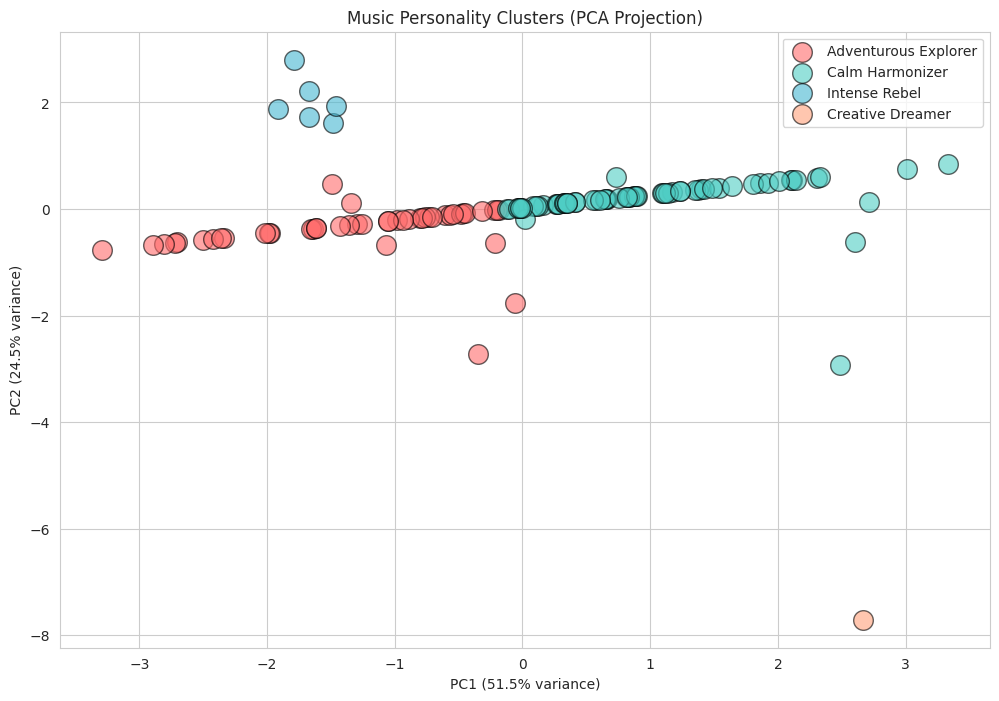

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load datasets from Databricks Volumes
indian_lyrics_df = pd.read_csv("/Volumes/workspace/default/dataset/indian_lyrics_lens_dataset.csv")
sample_lyrics_df = pd.read_csv("/Volumes/workspace/default/dataset/lyrics_lens_sample_dataset.csv")

print("Indian Dataset:", indian_lyrics_df.shape)
print("Sample Dataset:", sample_lyrics_df.shape)

# Merge datasets
df = pd.concat([indian_lyrics_df, sample_lyrics_df], ignore_index=True)
print("\nIntegrated Dataset:", df.shape)

# ===========================================
# ✅ FIX: Ensure required columns exist + fill NaNs
# ===========================================
required_columns = ["danceability", "energy", "valence", "acousticness", "negativity", "arousal", "tempo"]
for col in required_columns:
    if col not in df.columns:
        df[col] = 0.5
df[required_columns] = df[required_columns].fillna(0.5)

# Create normalized tempo column (0–1)
df["tempo_norm"] = df["tempo"].apply(lambda x: x / 200 if not pd.isna(x) else 0.5)

# ===========================================
# ✅ Personality Trait Calculation (Big Five)
# ===========================================
def calculate_traits(row):
    return pd.Series({
        "Openness": min(row["danceability"]*0.4 + row["energy"]*0.35 + row["valence"]*0.25, 1.0),
        "Conscientiousness": min(row["acousticness"]*0.5 + (1 - abs(row["tempo_norm"] - 0.5)) * 0.3 + (1 - row["energy"] * 0.2), 1.0),
        "Extraversion": min(row["energy"]*0.4 + row["danceability"]*0.35 + row["valence"]*0.25, 1.0),
        "Agreeableness": min(row["valence"]*0.4 + row["acousticness"]*0.3 + (1 - row["negativity"] * 0.3), 1.0),
        "Neuroticism": min(row["negativity"]*0.4 + row["arousal"]*0.3 + (1 - row["valence"] * 0.3), 1.0)
    })

df[["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]] = (
    df.apply(calculate_traits, axis=1)
)

print("\n✅ Personality traits calculated!\n")

# ===========================================
# ✅ KMeans Clustering (4 Personality Archetypes)
# ===========================================
personality_features = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]

X = df[personality_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["personality_cluster"] = kmeans.fit_predict(X_scaled)

archetype_names = {
    0: "Adventurous Explorer",
    1: "Calm Harmonizer",
    2: "Intense Rebel",
    3: "Creative Dreamer"
}
df["personality_archetype"] = df["personality_cluster"].map(archetype_names)

# Show cluster centers back in actual measurement scale
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=personality_features
)
cluster_centers.index = [archetype_names[i] for i in cluster_centers.index]
print("\nCluster Centers (Original Scale):\n")
print(cluster_centers.round(3))

# ===========================================
# ✅ PCA Scatter Plot (visualizing clusters)
# ===========================================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for cluster_id, color in zip(sorted(archetype_names.keys()), colors):
    mask = (df["personality_cluster"].to_numpy() == cluster_id)
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=[color], label=archetype_names[cluster_id],
        s=200, alpha=0.6, edgecolors="black"
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("Music Personality Clusters (PCA Projection)")
plt.legend()
plt.show()

In [0]:
display(dbutils.fs.ls("/Volumes/workspace/default/dataset/"))


path,name,size,modificationTime
dbfs:/Volumes/workspace/default/dataset/indian_lyrics_lens_dataset.csv,indian_lyrics_lens_dataset.csv,9762,1762932735000
dbfs:/Volumes/workspace/default/dataset/lyrics_lens_sample_dataset.csv,lyrics_lens_sample_dataset.csv,3200,1762932735000


In [0]:
%py
print("Notebook is working")


Notebook is working


In [0]:
# EXPORT TO VOLUME (this cell must be clean)

export_path = "/Volumes/workspace/default/dataset/music_personality_profiles.csv"
df.to_csv(export_path, index=False)

print("✅ File exported successfully!")
print("📂 Location:", export_path)


✅ File exported successfully!
📂 Location: /Volumes/workspace/default/dataset/music_personality_profiles.csv
